In [1]:
import sys
sys.path.append("/Users/octavia/Dropbox/SVE_v2/utilities")
sys.path.append("/Users/octavia/Dropbox/SVE_v2/model")
sys.path.append('/Users/octavia/Dropbox/SVE_v2/GW_model')

infl_modules = ['philips_infl', 'connect_SVE', 'GA_infl']
modules = ['search_functions', 'plot_functions', 'load_model_output',
           'gw_functions', 'SVE_mass_check']

for mod in modules + infl_modules:
    if mod in sys.modules: 
        del sys.modules[mod]

from search_functions import *
from load_model_output import *
from SVE_mass_check import *

from gw_functions import *
from plot_functions import *

from philips_infl import *
from GA_infl import *
from connect_SVE import *

In [2]:
project_dir = "/Users/octavia/Dropbox/SVE_v2/"
base_name = "GW_GA_test"
base_dir = project_dir  + 'model_output/' + base_name 

print_input_params(base_dir)

batch:
	p : 5.0
sim:
	Ks : 1.0, 2.0, 3.0
	H_i : -0.1, -0.05, 0
common:
	tr : 20
	dt_print : 30


In [3]:
core = load_sims(base_dir)
core[['H_i', 'Ks', 'no_flow']]
# core = patchy_update(core)

,H_i,Ks,no_flow
"p-5.0/H_i-0,Ks-3.0/",0,3,False
"p-5.0/H_i--0.05,Ks-2.0/",-0.05,2,False
"p-5.0/H_i--0.1,Ks-3.0/",-0.1,3,True
"p-5.0/H_i--0.05,Ks-1.0/",-0.05,1,False
"p-5.0/H_i-0,Ks-1.0/",0,1,False
"p-5.0/H_i--0.1,Ks-1.0/",-0.1,1,False
"p-5.0/H_i-0,Ks-2.0/",0,2,False
"p-5.0/H_i--0.05,Ks-3.0/",-0.05,3,True
"p-5.0/H_i--0.1,Ks-2.0/",-0.1,2,True


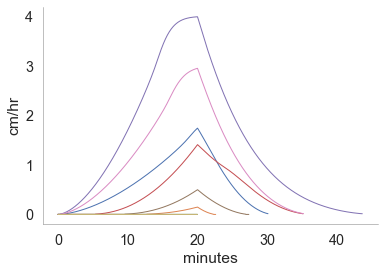

In [4]:
fig = plot_hydrographs(core)

In [5]:
sim =core.loc["p-5.0/H_i-0,Ks-3.0/"]

param = get_GW_param(sim, threshold=5e-5)
print (param['t_pond'])
res = Comparison_function2(param)
res = pd.Series(res)


param = get_philip_param(sim, threshold=5e-5)
philips_i =  compute_philip_infl(param)


0


(0, 3.15)

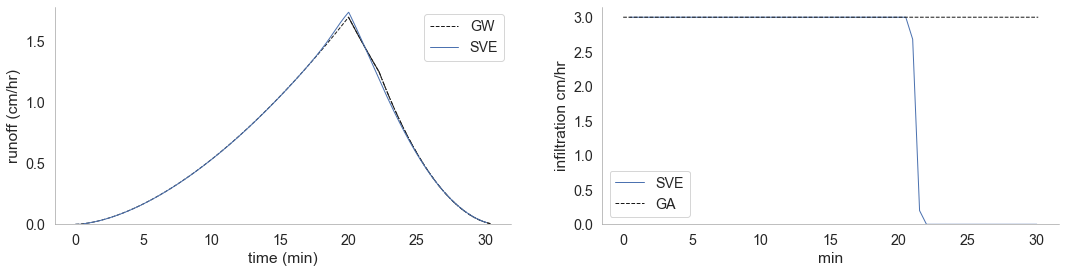

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (18, 4))
ax = axes[0]
ax.plot(res.t/60, res.q/res.L*3.6e5, 'k--', label = "GW")
ax.plot(res.t_d2/60, res.q_d2/res.L*3.6e5, 'k-')
ax.plot(res.t_d3/60, res.q_d3/res.L*3.6e5, 'k-.')
plt.xlabel("min")
ax.set_ylim(0, )
ax.plot(sim.t_h/60, sim.flux3/sim.area*3.6e5, '-', label = "SVE")
ax.legend()
ax.set_ylabel("runoff (cm/hr)")
ax.set_xlabel("time (min)")

ax = axes[1]
ax.plot(sim.t_print[1:]/60, sim.infl_3d[1:,0,0]*3.6e5, label = "SVE")
ax.plot(philips_i["t"]/60., philips_i["f"]*3.6e5, 'k--', label = "GA")
ax.set_ylabel("infiltration cm/hr")
plt.xlabel("min")
plt.legend()
ax.set_ylim(0, )

(0, 0.015675833333333337)

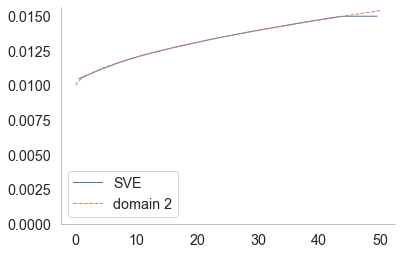

In [7]:
xf2 = res['x_f2']
tf2 = res['t_f2']
xf = res['x_f']
tf = res['t_f']
L = sim["Lx"]
fig, ax = plt.subplots(1)
ax.plot(sim.xc.mean(0), sim.infl_2d.mean(0), label = "SVE")
param = get_philip_param(sim)
if np.any(xf<L):
    I = compute_philip_F(param, tf[xf<L])
    ax.plot(xf[xf<L],  I , '--', label = "domain 1")
if np.any(xf2<L):
    I = compute_philip_F(param, tf2[xf2<L])
    ax.plot(xf2[xf2<L], I , '--', label = "domain 2")
ax.legend()
ax.set_ylim(0, )

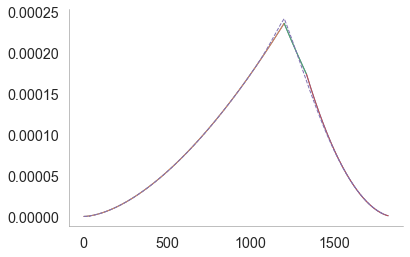

In [8]:
plt.plot(res['t'], res['q'])
plt.plot(res['t_d1'], res['q_d1'])
plt.plot(res['t_d2'], res['q_d2'])
plt.plot(res['t_d3'], res['q_d3'])

plt.plot(sim.t_h, sim.flux3/sim.Ly, '--')


In [9]:
from scipy import interpolate
def get_percent_diff(sim):
    """
    Compute SVE-GA / GW comparisoin for all simulations
    """

    param = get_GW_param(sim)
    res = Comparison_function2(param)
    res = pd.Series(res)

    f = interpolate.interp1d(res.t, res.q)
    tmax = min(res.t[-1], sim.t_h[-1])
    t_GW = sim.t_h[sim.t_h<tmax][1:]
    q_GW = f(t_GW)      #  m2/s
    
    q_SVE = sim.flux3/sim.Ly  # m3/s

    hydro_percent_diff = np.zeros_like(q_SVE)
    inds =  np.where(q_GW > sim.p*0.05)[0]
    hydro_percent_diff[inds] = (q_SVE[inds] - q_GW[inds])/q_SVE[inds]*100.
    hydro_percent_diff = hydro_percent_diff.mean()
    infl_frac_percent_diff = (sim.infl_frac - res.infl_frac)/sim.infl_frac*100

    return hydro_percent_diff, infl_frac_percent_diff


In [10]:
compare = {}
for key in core.index:
    sim = core.loc[key]
    if sim.hydro.mean() ==0.:
        continue
    else:
        compare[key] = {}
    compare[key]['p'] = core.loc[key]['p']
    compare[key]['So'] = core.loc[key]['So']*100   
    compare[key]['ksatV'] = core.loc[key]['ksatV']    
    compare[key]['H_i'] = core.loc[key]['H_i']      
    hydro_percent_diff, IF_percent_diff =  get_percent_diff(core.loc[key])
    compare[key]['hydro_percent_diff'] = np.round(hydro_percent_diff, 2)
    compare[key]['IF_percent_diff']  = np.round(IF_percent_diff, 2)
cols= [ 'p', 'So', 'KsV', 'hydro_percent_diff', 'IF_percent_diff']
compare = pd.DataFrame(compare).T